In [4]:
!pip install torchsummary

In [6]:
import einops
from tqdm.notebook import tqdm

from torchsummary import summary

import time

import torch
from torch import nn
import torchvision
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

patch_size = 16         # Patch size (P) = 16
latent_size = 768       # Latent vector (D). ViT-Base uses 768
n_channels = 3          # Number of channels for input images
num_heads = 12          # ViT-Base uses 12 heads
num_encoders = 12       # ViT-Base uses 12 encoder layers
dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
num_classes = 10        # Number of classes in CIFAR10 dataset
size = 224              # Size used for training = 224

epochs = 30             # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)
batch_size = 4

cpu


In [18]:
transform_training_data = Compose(
    [RandomCrop(32, padding=4), Resize((224)), RandomHorizontalFlip(), ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

train_data = torchvision.datasets.CIFAR10(
    root=r'C:\Users\Lenovo\Documents\building-ViT-from-scratch\ViT_CIFAR10_data', train=True, download=True, transform=transform_training_data)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:48<00:00, 3.53MB/s] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


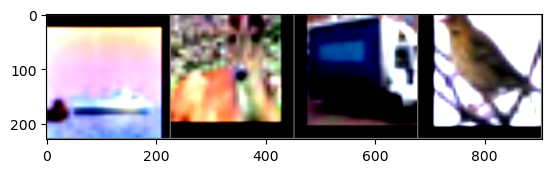

ship  deer  truck bird 


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [52]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, device=device, latent_size=latent_size):
        super(InputEmbedding, self).__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.device = device
        self.input_size = self.patch_size * self.patch_size * self.n_channels

        self.linearProjection = nn.Linear(self.input_size, self.latent_size)

        # Shared [CLS] token and positional embedding
        self.class_token = nn.Parameter(torch.randn(1, 1, self.latent_size))
        n_patches = (224 // patch_size) ** 2  # 14*14 = 196
        self.pos_embedding = nn.Parameter(torch.randn(1, n_patches + 1, self.latent_size))

    def forward(self, input_data):
        input_data = input_data.to(self.device)
        b = input_data.shape[0]

        # Patchify and project
        patches = einops.rearrange(input_data, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)', 
                                   h1=self.patch_size, w1=self.patch_size)
        linear_projection = self.linearProjection(patches)

        # Add [CLS] token and positional embedding
        cls_tokens = self.class_token.expand(b, -1, -1)
        linear_projection = torch.cat((cls_tokens, linear_projection), dim=1)

        pos_embed = self.pos_embedding[:, :linear_projection.size(1), :]
        linear_projection += pos_embed

        return linear_projection


In [54]:
test_input = torch.randn((4, 3, 224, 224))
test_class = InputEmbedding().to(device)
embed_test = test_class(test_input)

In [56]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size=latent_size, num_heads=num_heads, device=device, dropout=dropout):
        super(EncoderBlock, self).__init__()

        self.latent_size = latent_size
        self.num_heads = num_heads
        self.device = device
        self.dropout = dropout

        # Normalization layer for both sublayers
        self.norm = nn.LayerNorm(self.latent_size)
        
        # Multi-Head Attention layer
        self.multihead = nn.MultiheadAttention(
            self.latent_size, self.num_heads, dropout=self.dropout)          

        # MLP_head layer in the encoder. I use the same configuration as that 
        # used in the original VitTransformer implementation. The ViT-Base
        # variant uses MLP_head size 3072, which is latent_size*4.
        self.enc_MLP = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4, self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):

        # First sublayer: Norm + Multi-Head Attention + residual connection.
        # We take the first element ([0]) of the returned output from nn.MultiheadAttention()
        # because this module returns 'Tuple[attention_output, attention_output_weights]'. 
        # Refer to here for more info: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html 
        firstNorm_out = self.norm(embedded_patches)
        attention_output = self.multihead(firstNorm_out, firstNorm_out, firstNorm_out)[0]

        # First residual connection
        first_added_output = attention_output + embedded_patches

        # Second sublayer: Norm + enc_MLP (Feed forward)
        secondNorm_out = self.norm(first_added_output)
        ff_output = self.enc_MLP(secondNorm_out)

        # Return the output of the second residual connection
        return ff_output + first_added_output

In [58]:
test_encoder = EncoderBlock().to(device)
test_encoder(embed_test)

tensor([[[ 0.9044, -1.0200, -2.2656,  ..., -2.4734,  0.3442,  1.6900],
         [-0.2872,  0.7597, -1.0351,  ...,  1.7325,  1.8266,  1.0506],
         [-0.2163,  1.0560, -0.4155,  ..., -0.0435, -0.6536,  2.4764],
         ...,
         [-2.0823,  0.4630, -1.8122,  ..., -0.2467, -0.3969,  0.6561],
         [ 1.5169, -1.3326, -0.8012,  ...,  1.1319,  0.3236, -1.7114],
         [ 0.7432,  1.0894,  0.1934,  ...,  0.6970,  0.6578,  2.3110]],

        [[ 1.1208, -1.0180, -2.2303,  ..., -2.2652,  0.4014,  1.1836],
         [-0.0627, -0.2825, -0.6958,  ...,  1.3230,  1.7040,  0.2859],
         [ 0.8574,  1.4376, -0.7731,  ..., -0.1249, -0.0651,  2.3315],
         ...,
         [-1.9837,  0.2065, -1.3668,  ..., -0.5613,  0.6043,  1.4048],
         [ 2.0244, -1.8785, -1.8833,  ...,  1.9961, -0.1954, -0.1763],
         [ 0.6851,  1.5950, -1.6020,  ...,  0.5758,  1.5395,  1.2628]],

        [[ 1.0459, -1.1012, -2.2488,  ..., -2.2419,  0.3098,  1.6203],
         [ 0.1769,  0.6527, -0.5089,  ...,  1

In [60]:
class VitTransformer(nn.Module):
    def __init__(self, num_encoders=num_encoders, latent_size=latent_size, device=device, num_classes=num_classes, dropout=dropout):
        super(VitTransformer, self).__init__()
        self.num_encoders = num_encoders
        self.latent_size = latent_size
        self.device = device
        self.num_classes = num_classes
        self.dropout = dropout

        self.embedding = InputEmbedding()

        # Create a stack of encoder layers
        self.encStack = nn.ModuleList([EncoderBlock() for i in range(self.num_encoders)])

        # MLP_head at the classification stage has 'one hidden layer at pre-training time
        # and by a single linear layer at fine-tuning time'. For this implementation I will
        # use what was used for training, so I'll have a total of two layers, one hidden
        # layer and one output layer.
        self.MLP_head = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.num_classes)
        )

    def forward(self, test_input):

        # Apply input embedding (patchify + linear projection + position embeding)
        # to the input image passed to the model
        enc_output = self.embedding(test_input)

        # Loop through all the encoder layers
        for enc_layer in self.encStack:
            enc_output = enc_layer.forward(enc_output)

        # Extract the output embedding information of the [class] token
        cls_token_embedding = enc_output[:, 0]

        # Finally, return the classification vector for all image in the batch
        return self.MLP_head(cls_token_embedding)

In [62]:
model = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)

# Betas used for Adam in paper are 0.9 and 0.999, which are the default in PyTorch
optimizer = optim.Adam(model.parameters(), lr=base_lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.LinearLR(optimizer)

In [64]:
summary(model,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 196, 768]         590,592
    InputEmbedding-2             [-1, 197, 768]               0
         LayerNorm-3             [-1, 197, 768]           1,536
MultiheadAttention-4  [[-1, 197, 768], [-1, 2, 2]]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 3072]       2,362,368
              GELU-7            [-1, 197, 3072]               0
           Dropout-8            [-1, 197, 3072]               0
            Linear-9             [-1, 197, 768]       2,360,064
          Dropout-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
MultiheadAttention-12  [[-1, 197, 768], [-1, 2, 2]]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            

In [70]:
import matplotlib.pyplot as plt

def main():
    model.train().to(device)

    epoch_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        batch_losses = []

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_losses.append(loss.item())

            # Print every 200 batches
            if (batch_idx + 1) % 200 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}], Loss: {running_loss / 200:.4f}")
                running_loss = 0.0

        # Average loss per epoch
        epoch_avg_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_avg_loss)
        print(f">>> Epoch [{epoch+1}/{epochs}] Average Loss: {epoch_avg_loss:.4f}")

        scheduler.step()

    # Plot loss vs. epoch
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o', color='blue', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [72]:
if __name__ == "__main__":
    main()

Epoch [1/30], Batch [200], Loss: 2.3229
Epoch [1/30], Batch [400], Loss: 2.3069
Epoch [1/30], Batch [600], Loss: 2.3057
Epoch [1/30], Batch [800], Loss: 2.3046
Epoch [1/30], Batch [1000], Loss: 2.3045
Epoch [1/30], Batch [1200], Loss: 2.3027
Epoch [1/30], Batch [1400], Loss: 2.3041
Epoch [1/30], Batch [1600], Loss: 2.3024
Epoch [1/30], Batch [1800], Loss: 2.3050
Epoch [1/30], Batch [2000], Loss: 2.3036
Epoch [1/30], Batch [2200], Loss: 2.3019
Epoch [1/30], Batch [2400], Loss: 2.3046
Epoch [1/30], Batch [2600], Loss: 2.3038
Epoch [1/30], Batch [2800], Loss: 2.3035
Epoch [1/30], Batch [3000], Loss: 2.3039
Epoch [1/30], Batch [3200], Loss: 2.3033
Epoch [1/30], Batch [3400], Loss: 2.3046
Epoch [1/30], Batch [3600], Loss: 2.3034
Epoch [1/30], Batch [3800], Loss: 2.3025
Epoch [1/30], Batch [4000], Loss: 2.3039


KeyboardInterrupt: 